In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chisquare
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier


import imblearn
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_selection import chi2
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
import os


# EDA

In [2]:
#Reading teh data from kaggle local storage
df = pd.read_csv("/kaggle/input/diabetes-health-indicators-dataset/diabetes_binary_health_indicators_BRFSS2015.csv")
print(df.columns)
print(df.info())

Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          25368

In [3]:
#Predicot Columns and teh Target columns bifurcation
target = 'Diabetes_binary'
feats = [col for col in df.columns if col!=target]

X = df[feats]

y=df[target]

In [4]:
#Number of unique values in each column! All the columns expect BMI are discrete whereas BMI is an approximation
col_types = {}
for col in df.columns:
    if(col != target):
        col_types[col] = df.groupby([col]).count()[target].shape[0]
print(col_types)

{'HighBP': 2, 'HighChol': 2, 'CholCheck': 2, 'BMI': 84, 'Smoker': 2, 'Stroke': 2, 'HeartDiseaseorAttack': 2, 'PhysActivity': 2, 'Fruits': 2, 'Veggies': 2, 'HvyAlcoholConsump': 2, 'AnyHealthcare': 2, 'NoDocbcCost': 2, 'GenHlth': 5, 'MentHlth': 31, 'PhysHlth': 31, 'DiffWalk': 2, 'Sex': 2, 'Age': 13, 'Education': 6, 'Income': 8}


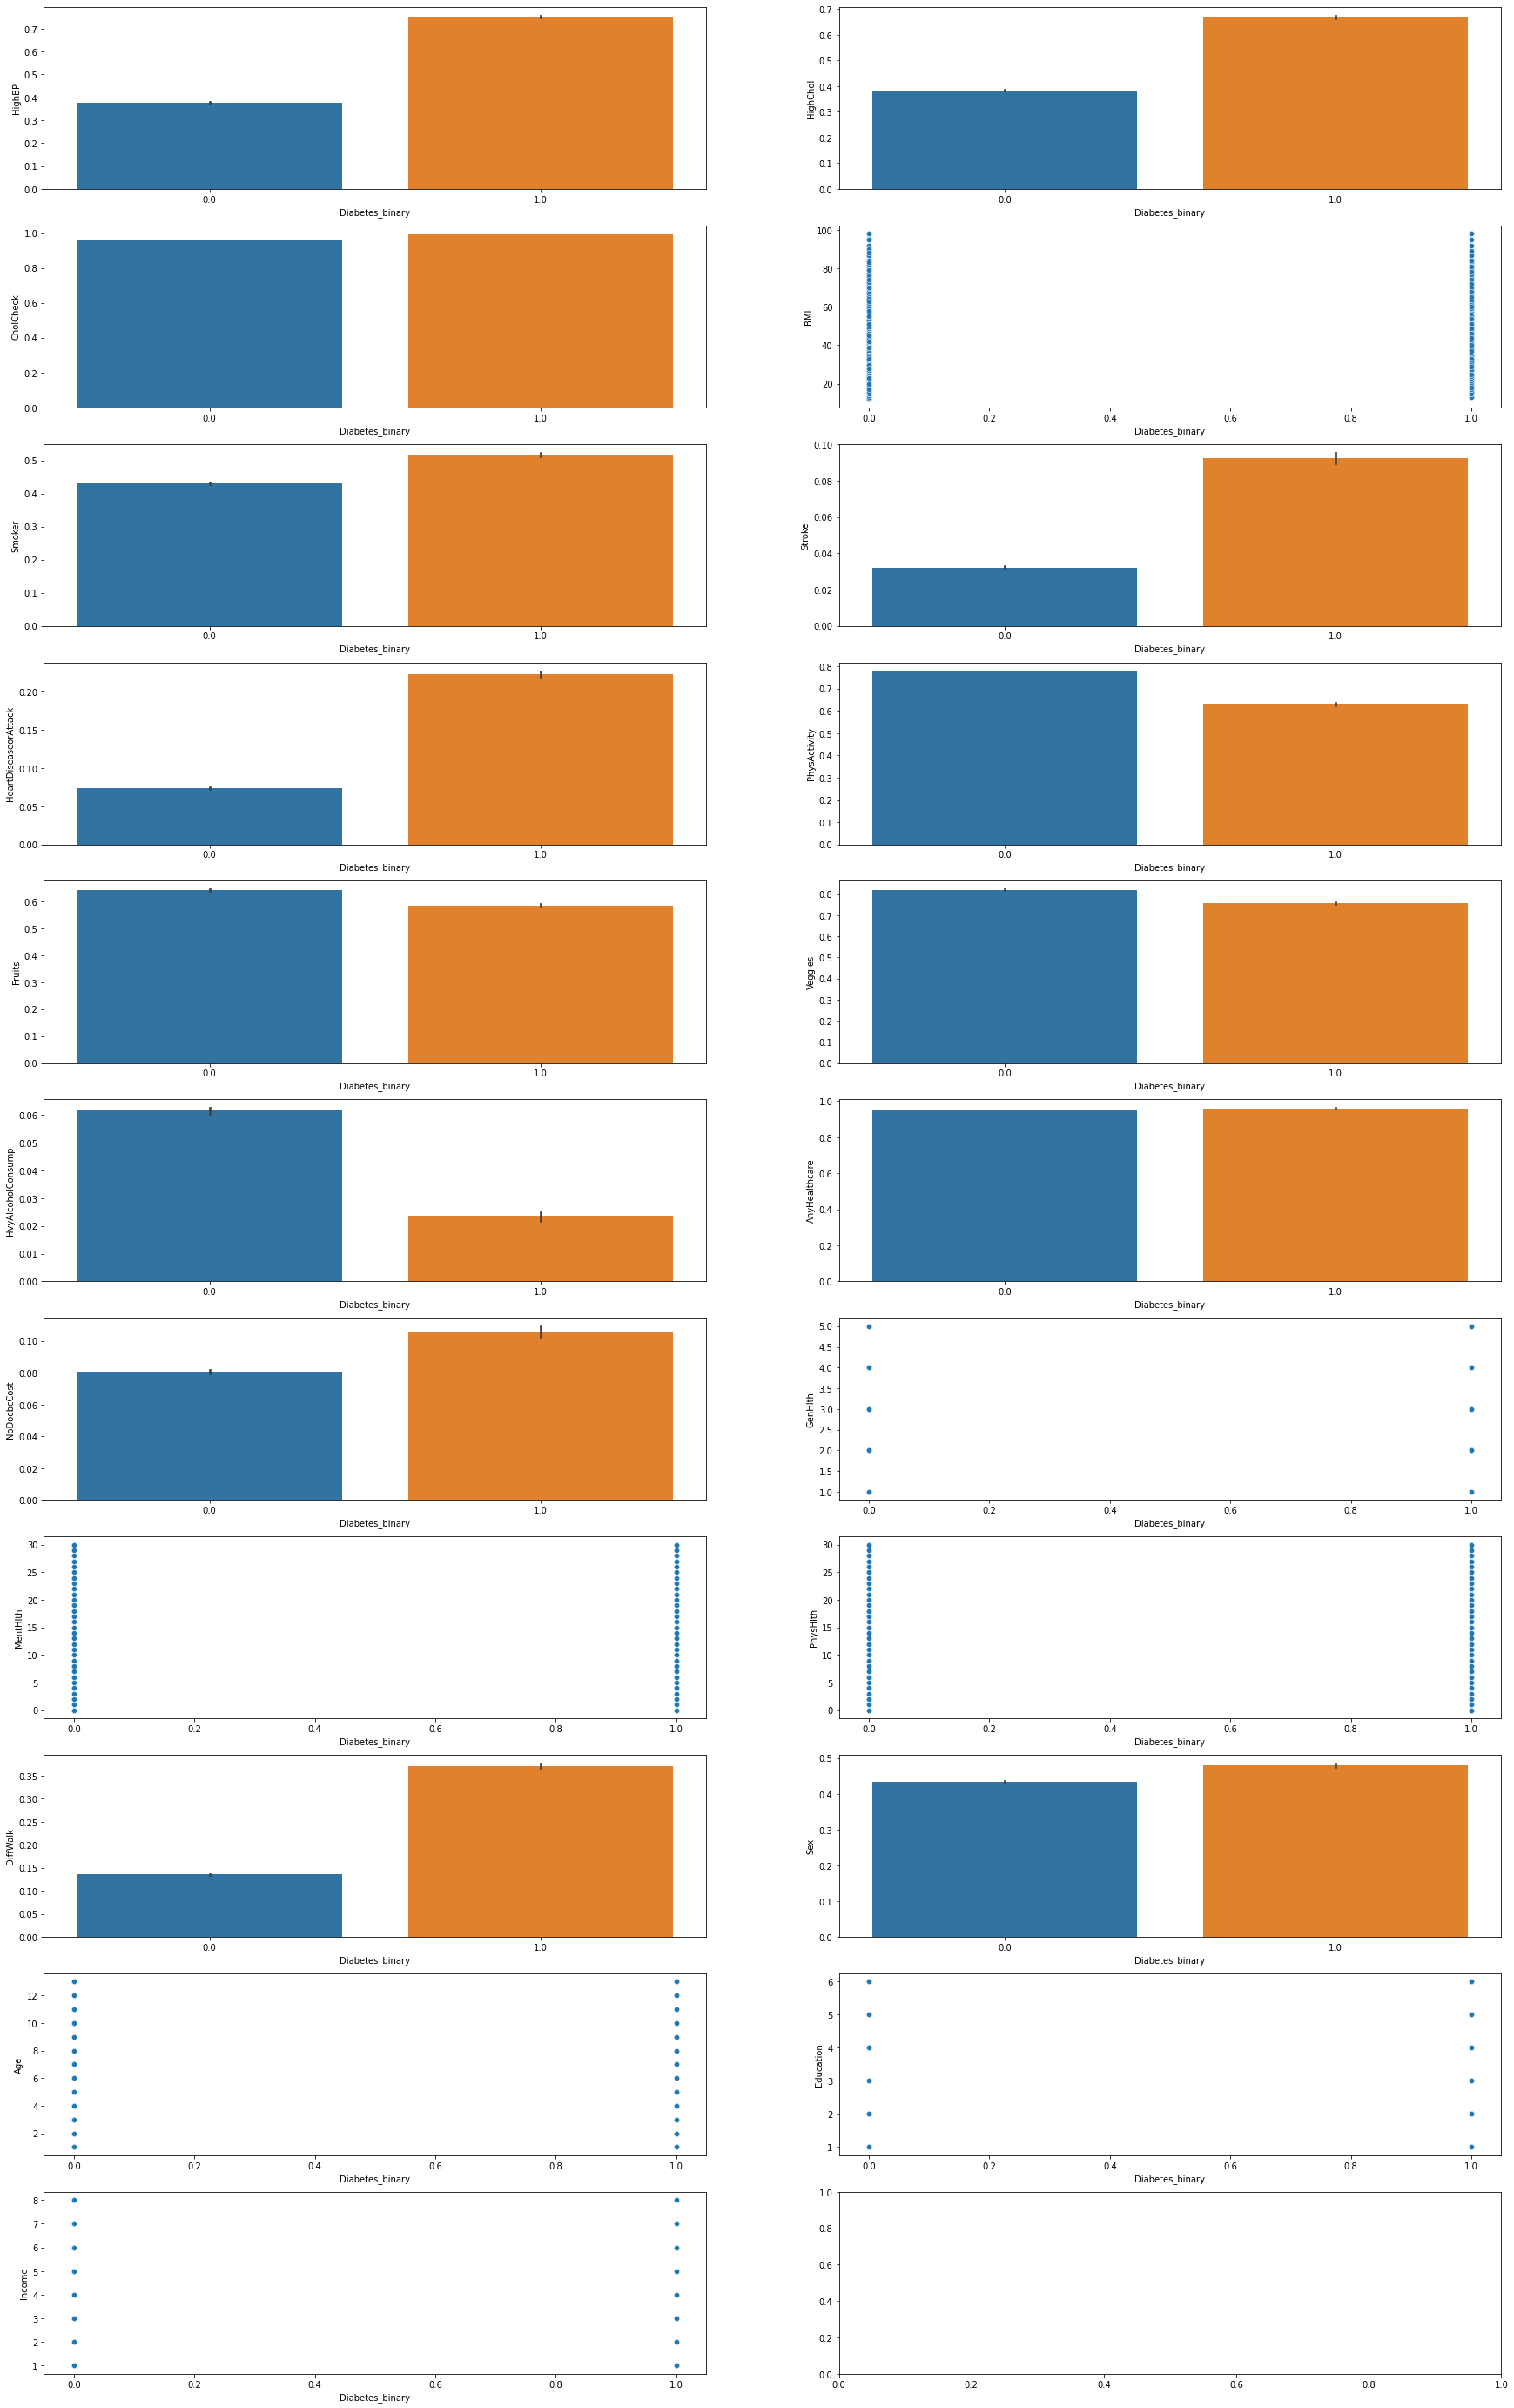

The disparity in the heights of bars indicate the dependence between of the target and predictor variables.Higher the disparity higher the importance of the feature


In [5]:
fig,ax=plt.subplots(11,2,figsize = (30,50))
i=0
row = 0
col = 0
for col in df.columns:
    if(col!=target):
        
        r = int(i/2)
        c = i % 2
        if(col_types[col]>2):
            sns.scatterplot(df[target],df[col],ax=ax[r][c])
        if(col_types[col]<=2):
            sns.barplot(df[target],df[col],ax=ax[r][c])
        i=i+1
            
plt.show()
            
print('The disparity in the heights of bars indicate the dependence between of the target and predictor variables.Higher the disparity higher the importance of the feature') 

# Feature Dependence
Since most of the columns are categorical it is not advisable to use corelation to eliminate any features and hence we are resorting to Chi-Square test ; Mutual Information Score

In [6]:
# HighCol, Stroke,HeartDiseaseorAttack seem to be dependent intuitively
#Chi-Square test
def chi2_independence(col1,col2):
    vals = X.groupby([col1,col2]).count()['BMI'].values
    X.groupby([col1,col2]).count()['BMI']
    col1_p0 = X[X[col1]==0].shape[0]/X.shape[0]
    col2_p0 = X[X[col2]==0].shape[0]/X.shape[0]
    exp =  [X.shape[0] *col1_p0*col2_p0,X.shape[0] *col1_p0*(1-col2_p0),X.shape[0] *(1-col1_p0)*col2_p0,X.shape[0] *(1-col1_p0)*(1-col2_p0)]
    return stats.chisquare(vals,exp).pvalue

p1 = chi2_independence('Stroke','HeartDiseaseorAttack')
print(p1)
p1 = chi2_independence('Stroke','HighChol')
print(p1)
p1 = chi2_independence('HighBP','HighChol')
print(p1)


0.0
0.0
0.0


In [7]:
#Mutual Information Score
print(normalized_mutual_info_score(X['Stroke'],X['HeartDiseaseorAttack'] ))
print(normalized_mutual_info_score(X['Stroke'],X['HighChol'] ))
print(normalized_mutual_info_score(X['HighBP'],X['HighChol'] ))
print(normalized_mutual_info_score(X['PhysActivity'],X['HighChol'] ))
print(normalized_mutual_info_score(X['PhysActivity'],X['HighChol'] ))

0.054048215808367384
0.00996148634395325
0.065721767854643
0.004891435530549298
0.004891435530549298


In [8]:

print(X.corr().unstack().sort_values().drop_duplicates().head(5))
print(X.corr().unstack().sort_values(ascending=False).drop_duplicates().head(5))
print('Colums are not heavily linearly corelated. So cant use this to filter out any!')

Income        GenHlth    -0.370014
DiffWalk      Income     -0.320124
Education     GenHlth    -0.284912
Income        PhysHlth   -0.266799
PhysActivity  GenHlth    -0.266186
dtype: float64
HighBP     HighBP      1.000000
GenHlth    PhysHlth    0.524364
PhysHlth   DiffWalk    0.478417
DiffWalk   GenHlth     0.456920
Education  Income      0.449106
dtype: float64
Colums are not heavily linearly corelated. So cant use this to filter out any!


# Hypothesis Testing




### **Q1** - CDC has a simple [form](https://www.cdc.gov/prediabetes/takethetest/) to help a candidate understand whether he/she is diabetic. If the candidate is "safe" with respect to the select features the result is that the candidate is not diabetic. We want to validate this hypothesis using the data we have
#### **Assumptions**: Obviously this wouldnt be 100% accurate but with an alpha of 1-2% would this be accurate?

#### **Steps**
1. Choose the hypothesis test
2. Data Prep.
3. Perform the test
4. Conclude
5. Explanation

In [9]:
#Prepping the data for hypothesis testing - Making them all booleans
ht_columns = ['Age','GenHlth','PhysActivity','BMI','Smoker']
ht = X[ht_columns]

ht['Age'] = (ht['Age']>4).astype('int')
ht['GenHlth'] = (ht['GenHlth']<3).astype('int')
ht['BMI'] = ((ht['BMI']<=25) & (ht['BMI']>=18)).astype('int')
ht['Sum']=ht.sum(axis=1)
ht['target']= y
ht.head()

,Age,GenHlth,PhysActivity,BMI,Smoker,Sum,target
0,1,0,0.0,0,1.0,2.0,0.0
1,1,0,1.0,1,1.0,4.0,0.0
2,1,0,0.0,0,0.0,1.0,0.0
3,1,1,1.0,0,0.0,3.0,0.0
4,1,1,1.0,1,0.0,4.0,0.0


In [10]:

#"Sum" column being 0 represents that we are in the "safe-zone" with respect to all the features picked by CDC
ht['safe_feat'] = (ht['Sum']<1).astype('int')
freq_obs = [ht[(ht['safe_feat']==1) & (ht['target']==1)].shape[0],ht[(ht['safe_feat']==1) & (ht['target']==0)].shape[0]]
#Because the expected is that "safe-zone" is free of diabetes
#Instead of using "0" in the expected as formulas might have issues we take it as 10
freq_exp = [10,sum(freq_obs)-10]

chisquare(freq_obs).pvalue

1.0892107243999514e-214

In [11]:
print(freq_obs)

[110, 1273]


##### Conclusion
pValue is quite low. So we can reject the null hypothesis and conclude that there is a significant impact 

### Q2 - Does it make sense to have different models for younger individuals vs older individuals?
1. Splitting around the age of 40 years let us check this.
2. Build different models for the datasets
3. Compare feature importances in the resultant models using paired t-test
(If the feature importances differ for younger and older individuals we need different models)

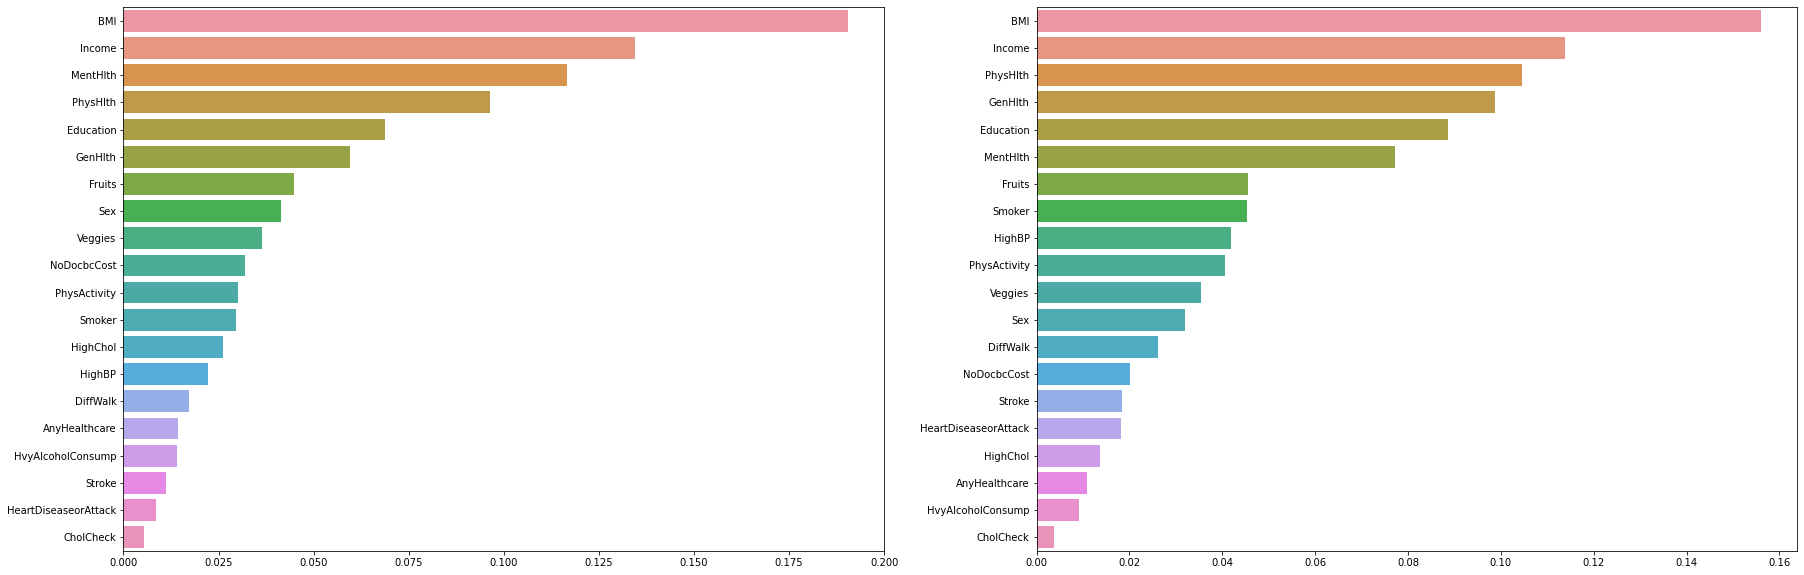

In [12]:

clf_young = DecisionTreeClassifier(random_state=0)
clf_old = DecisionTreeClassifier(random_state=0)
col_name = 'Age'
cur_feats = [col for col in feats if col!=col_name]
#Data split to build two different models
X_young = X[X[col_name]<=4][cur_feats]
y_young = y[X[col_name]<=4]
X_old = X[X[col_name]>4][cur_feats]
y_old = y[X[col_name]>4]
#Data Frame with feature importance results
model_diff=pd.DataFrame()

fig,ax=plt.subplots(1,2,figsize=(30,10))
#Model for younger
clf_young.fit(X_young,y_young)
feat_imp_young=pd.Series(clf_young.feature_importances_)
model_diff['young'] = feat_imp_young
feat_imp_young.index=cur_feats
feat_imp_young = feat_imp_young.sort_values(ascending=False)
#Plotting feature importances
sns.barplot(y=feat_imp_young.index,x=feat_imp_young,ax=ax[0])

#Model for older
clf_old.fit(X_old,y_old)
feat_imp_old=pd.Series(clf_old.feature_importances_)
model_diff['old'] = feat_imp_old
feat_imp_old.index=cur_feats
feat_imp_old = feat_imp_old.sort_values(ascending=False)
#plotting feat importances
sns.barplot(y=feat_imp_old.index,x=feat_imp_old,ax=ax[1])

model_diff.index=cur_feats

In [13]:

stats.ttest_rel(model_diff['young'], model_diff['old'])

Ttest_relResult(statistic=-5.423594165017478e-16, pvalue=0.9999999999999996)

##### Conclusion:
p Value is very high and hence we know that the models are not very different and hence we do not need to split and build different for younger and older individuals

### Q3 - Does it make sense to have different models for female individuals vs male individuals?
1. Splitting the data for male and female.
2. Build different models for the datasets
3. Compare feature importances in the resultant models using paired t-test
(If the feature importances differ for female and male individuals we need different models)

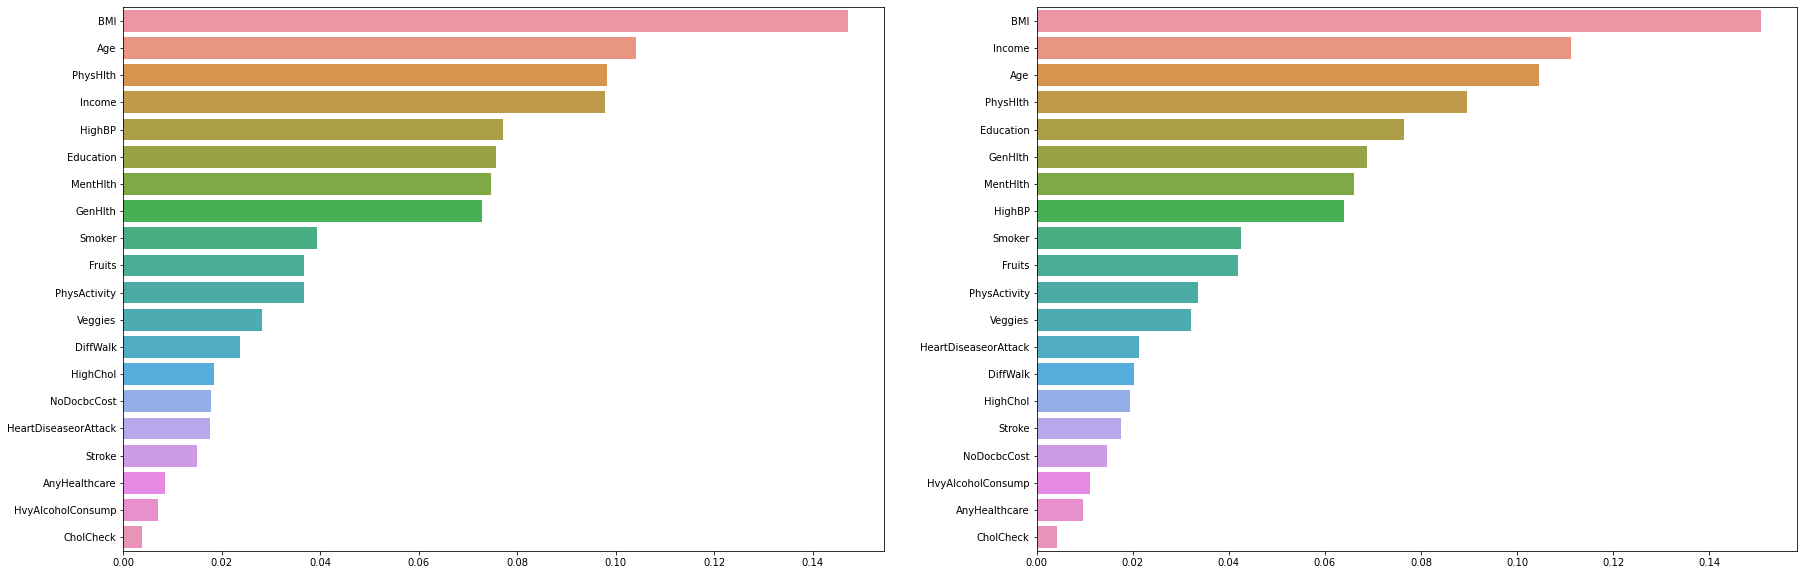

In [14]:


clf_male = DecisionTreeClassifier(random_state=0)
clf_female = DecisionTreeClassifier(random_state=0)

#Data split to build two different models
col_name = 'Sex'
cur_feats = [col for col in feats if col!=col_name]
X_female = X[X[col_name]==0][cur_feats]
y_female = y[X[col_name]==0]
X_male = X[X[col_name]==1][cur_feats]
y_male = y[X[col_name]==1]
#Data Frame with feature importance results
model_diff=pd.DataFrame()

fig,ax=plt.subplots(1,2,figsize=(30,10))
#Model for female
clf_female.fit(X_female,y_female)
feat_imp_female=pd.Series(clf_female.feature_importances_)
model_diff['female'] = feat_imp_female
feat_imp_female.index=cur_feats
feat_imp_female = feat_imp_female.sort_values(ascending=False)
#Plotting feature importances
sns.barplot(y=feat_imp_female.index,x=feat_imp_female,ax=ax[0])

#Model for male
clf_male.fit(X_male,y_male)
feat_imp_male=pd.Series(clf_male.feature_importances_)
model_diff['male'] = feat_imp_male
feat_imp_male.index=cur_feats
feat_imp_male = feat_imp_male.sort_values(ascending=False)
#plotting feat importances
sns.barplot(y=feat_imp_male.index,x=feat_imp_male,ax=ax[1])

model_diff.index=cur_feats

In [15]:

stats.ttest_rel(model_diff['female'], model_diff['male'])

Ttest_relResult(statistic=-4.814756698945561e-15, pvalue=0.9999999999999962)

### Q4 - Does it make sense to have different models for Smoker individuals vs Non-Smoker individuals?
1. Splitting the data for male and female.
2. Build different models for the datasets
3. Compare feature importances in the resultant models using paired t-test
(If the feature importances differ for female and male individuals we need different models)

Ttest_relResult(statistic=-2.006351248654122e-15, pvalue=0.9999999999999984)

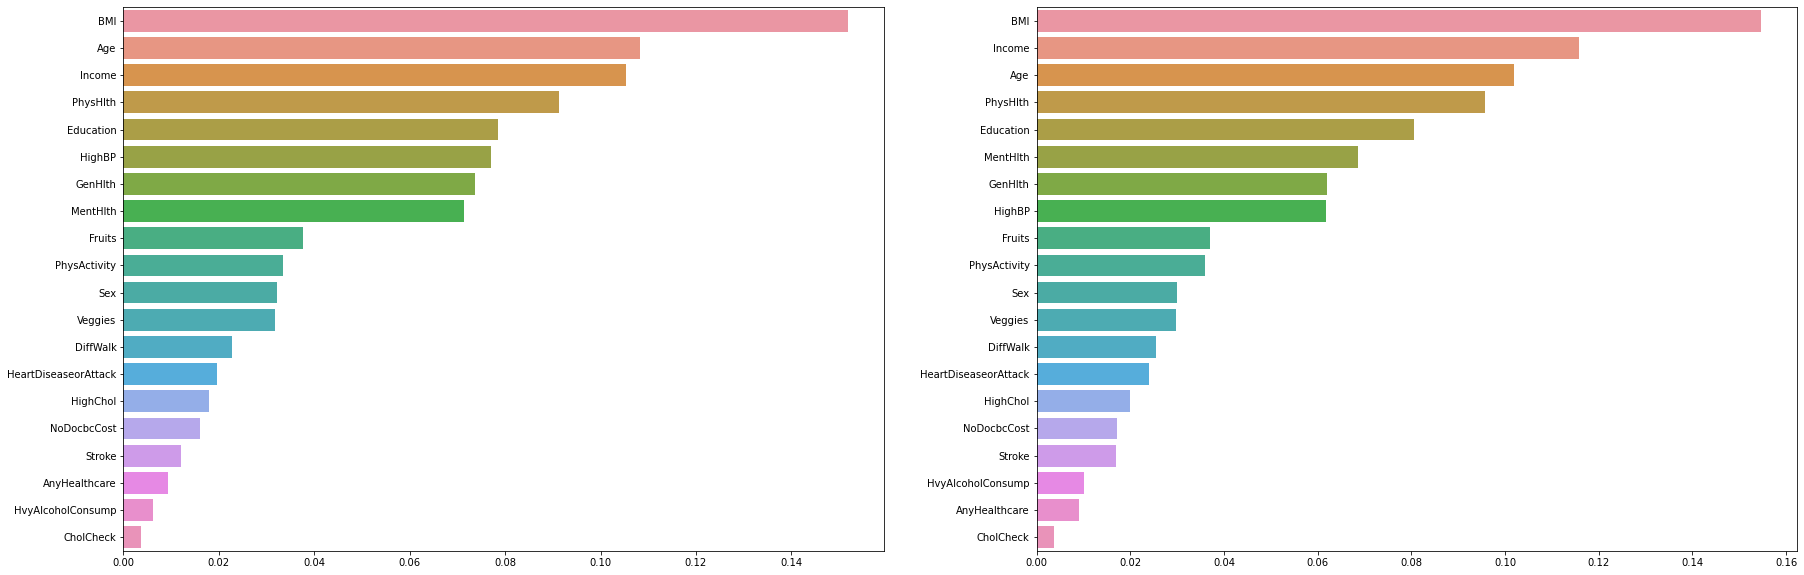

In [16]:


clf_male = DecisionTreeClassifier(random_state=0)
clf_female = DecisionTreeClassifier(random_state=0)

#Data split to build two different models
col_name = 'Smoker'
cur_feats = [col for col in feats if col!=col_name]
X_female = X[X[col_name]==0][cur_feats]
y_female = y[X[col_name]==0]
X_male = X[X[col_name]==1][cur_feats]
y_male = y[X[col_name]==1]
#Data Frame with feature importance results
model_diff=pd.DataFrame()

fig,ax=plt.subplots(1,2,figsize=(30,10))
#Model for female
clf_female.fit(X_female,y_female)
feat_imp_female=pd.Series(clf_female.feature_importances_)
model_diff['non_smoker'] = feat_imp_female
feat_imp_female.index=cur_feats
feat_imp_female = feat_imp_female.sort_values(ascending=False)
#Plotting feature importances
sns.barplot(y=feat_imp_female.index,x=feat_imp_female,ax=ax[0])

#Model for male
clf_male.fit(X_male,y_male)
feat_imp_male=pd.Series(clf_male.feature_importances_)
model_diff['smoker'] = feat_imp_male
feat_imp_male.index=cur_feats
feat_imp_male = feat_imp_male.sort_values(ascending=False)
#plotting feat importances
sns.barplot(y=feat_imp_male.index,x=feat_imp_male,ax=ax[1])

model_diff.index=cur_feats

stats.ttest_rel(model_diff['non_smoker'], model_diff['smoker'])

In [17]:
X.groupby(['NoDocbcCost']).count()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
NoDocbcCost,,,,,,,,,,,,,,,,,,,,
0.0,232326,232326,232326,232326,232326,232326,232326,232326,232326,232326,232326,232326,232326,232326,232326,232326,232326,232326,232326,232326
1.0,21354,21354,21354,21354,21354,21354,21354,21354,21354,21354,21354,21354,21354,21354,21354,21354,21354,21354,21354,21354


### Q3 - Does it make sense to have different models for NoDoctorBcos Of Cost individuals vs No Cost Problem individuals?
1. Splitting the data for male and female.
2. Build different models for the datasets
3. Compare feature importances in the resultant models using paired t-test
(If the feature importances differ for female and male individuals we need different models)

Ttest_relResult(statistic=0.0, pvalue=1.0)

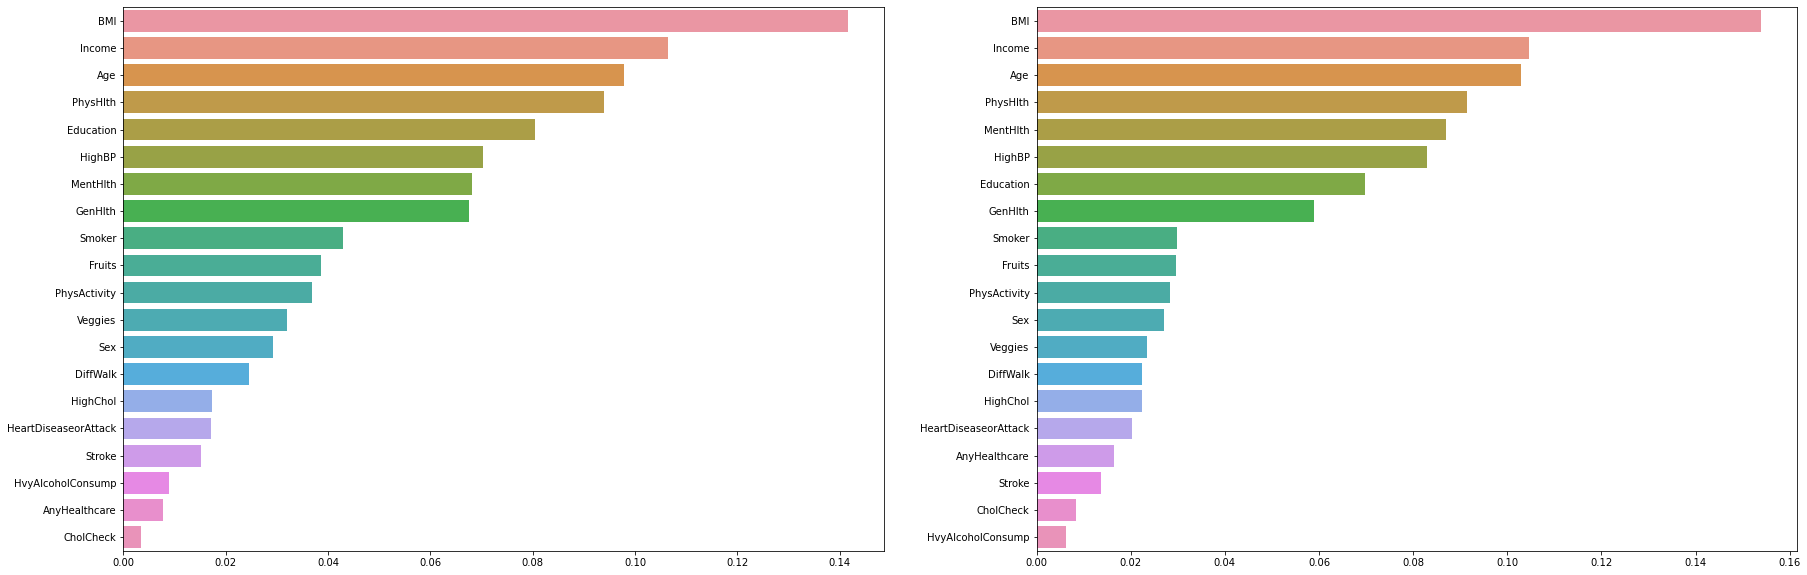

In [18]:


clf_male = DecisionTreeClassifier(random_state=0)
clf_female = DecisionTreeClassifier(random_state=0)

#Data split to build two different models
col_name = 'NoDocbcCost'
cur_feats = [col for col in feats if col!=col_name]
X_female = X[X[col_name]==0][cur_feats]
y_female = y[X[col_name]==0]
X_male = X[X[col_name]==1][cur_feats]
y_male = y[X[col_name]==1]
#Data Frame with feature importance results
model_diff=pd.DataFrame()

fig,ax=plt.subplots(1,2,figsize=(30,10))
#Model for female
clf_female.fit(X_female,y_female)
feat_imp_female=pd.Series(clf_female.feature_importances_)
model_diff['costProb'] = feat_imp_female
feat_imp_female.index=cur_feats
feat_imp_female = feat_imp_female.sort_values(ascending=False)
#Plotting feature importances
sns.barplot(y=feat_imp_female.index,x=feat_imp_female,ax=ax[0])

#Model for male
clf_male.fit(X_male,y_male)
feat_imp_male=pd.Series(clf_male.feature_importances_)
model_diff['noCostProb'] = feat_imp_male
feat_imp_male.index=cur_feats
feat_imp_male = feat_imp_male.sort_values(ascending=False)
#plotting feat importances
sns.barplot(y=feat_imp_male.index,x=feat_imp_male,ax=ax[1])

model_diff.index=cur_feats

stats.ttest_rel(model_diff['costProb'], model_diff['noCostProb'])

# Data Prep
Using Random Forest
1. Perform classification with PCA
2. Perform calssification without PCA

In [19]:
#Split into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# Split train into train and CV
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
#Oversample data
oversample = RandomOverSampler(sampling_strategy=0.5)
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [20]:
#Scaling Data - Standard Sclaer before PCA
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

#Performing PCA where we just pick the features that cover 85% of the variance
pca = PCA(n_components=0.85)
pca.fit(X_train_std)
len(pca.components_)
X_train_std_pca = pca.transform(X_train_std)
X_test_std_pca = pca.transform(X_test_std)

X_over_pca, y_over_pca = oversample.fit_resample(X_train_std_pca, y_train)

# Feature Importance

Esimators : 50, min_samples_split : 40,min_samples_leaf: 10
CV Score - 0.8182003327907837
Train Score - 0.8546437756735128
Esimators : 50, min_samples_split : 40,min_samples_leaf: 20
CV Score - 0.8144340294696778
Train Score - 0.8416189919297549
Esimators : 50, min_samples_split : 50,min_samples_leaf: 10
CV Score - 0.8160714261833704
Train Score - 0.8496689672584709
Esimators : 50, min_samples_split : 50,min_samples_leaf: 20
CV Score - 0.8153765246155346
Train Score - 0.8404977402031811
Esimators : 100, min_samples_split : 40,min_samples_leaf: 10
CV Score - 0.8188852463434139
Train Score - 0.856654597046605
Esimators : 100, min_samples_split : 40,min_samples_leaf: 20
CV Score - 0.8150219415862664
Train Score - 0.8424092361761644
Esimators : 100, min_samples_split : 50,min_samples_leaf: 10
CV Score - 0.8180171432400676
Train Score - 0.85082750758946
Esimators : 100, min_samples_split : 50,min_samples_leaf: 20
CV Score - 0.8156434912702656
Train Score - 0.8408713283510675
Esimators : 150

<AxesSubplot:>

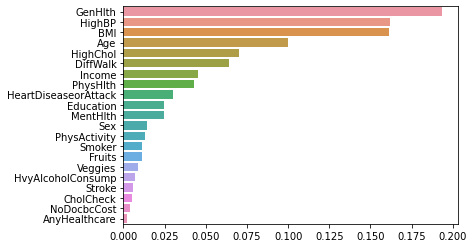

In [21]:
feat_imp=np.zeros(len(feats))

cnt=0
for n in range(50,200,50):
#     for d in range(5,20,5):
            for m in range(40,60,10):
                    for m2 in range(10,30,10):
                        clf = RandomForestClassifier(n_estimators = n,min_samples_split=m,min_samples_leaf=m2)
                        clf.fit(X_over,y_over)
                        print(f'Esimators : {n}, min_samples_split : {m},min_samples_leaf: {m2}')
                        print(f'CV Score - {f1_score(clf.predict(X_cv),y_cv,average="weighted")}')
                        print(f'Train Score - {f1_score(clf.predict(X_train),y_train,average="weighted")}')
                        feat_imp = feat_imp+clf.feature_importances_
                        cnt=cnt+1
feat_imp = feat_imp/cnt
feat_imp=pd.Series(feat_imp)

#plotting feat importances
feat_imp.index=feats
feat_imp = feat_imp.sort_values(ascending=False)
sns.barplot(y=feat_imp.index,x=feat_imp)



# Possible Feature Elmination

In [22]:
A = X.copy()
A['Food'] = A['Fruits']+A['Veggies']
A.drop(columns=['Fruits','Veggies'],inplace=True)
A['lifeStyle'] = A['Smoker']+A['HvyAlcoholConsump']
A.drop(columns=['Smoker','HvyAlcoholConsump'],inplace=True)
A.drop(columns=['CholCheck','NoDocbcCost','AnyHealthcare'],inplace=True)


A_train,A_test,Ay_train,Ay_test = train_test_split(A,y,test_size=0.33,random_state=0)
A_over, Ay_over = oversample.fit_resample(A_train, Ay_train)

# Modeling

### Baseline Model

In [23]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

print(f'Test Score - {f1_score(dummy_clf.predict(X_test),y_test)}')
print(f'Train Score - {f1_score(dummy_clf.predict(X_train),y_train)}')

print(f'Test Score - {accuracy_score(dummy_clf.predict(X_test),y_test)}')
print(f'Train Score - {accuracy_score(dummy_clf.predict(X_train),y_train)}')

print(f'Test Score - {precision_score(dummy_clf.predict(X_test),y_test)}')
print(f'Train Score - {precision_score(dummy_clf.predict(X_train),y_train)}')
print(f'Test Score - {recall_score(dummy_clf.predict(X_test),y_test)}')
print(f'Train Score - {recall_score(dummy_clf.predict(X_train),y_train)}')

Test Score - 0.0
Train Score - 0.0
Test Score - 0.8621513468315116
Train Score - 0.8598387719976114
Test Score - 0.0
Train Score - 0.0
Test Score - 0.0
Train Score - 0.0


## Impact of OverSampling the data for imbalanced classification problems
## Impact of PCA on the data like this which is mostly categorical

In [24]:
print('Logistic Regression Classification')
print('--------------------------------------------------------------')
#Decision Tree as a model slightly better than baseline
print('Imbalanced')
clf = LogisticRegression(solver='liblinear')
clf.fit(X_train,y_train)
print(f'Test Score - {f1_score(clf.predict(X_test),y_test)}')
print(f'Train Score - {f1_score(clf.predict(X_train),y_train)}')



#Comparing Decision Tree performance on imbalanced data vs Oversampled data
print('Oversampled')
clf = LogisticRegression(solver='liblinear')
clf.fit(X_over,y_over)
print(f'Test Score - {f1_score(clf.predict(X_test),y_test)}')
print(f'Train Score - {f1_score(clf.predict(X_train),y_train)}')

print('PCA and oversampled')
clf = LogisticRegression(solver='liblinear')
clf.fit(X_over_pca,y_over_pca)
print(f'Test Score - {f1_score(clf.predict(X_test_std_pca),y_test)}')
print(f'Train Score - {f1_score(clf.predict(X_train_std_pca),y_train)}')

print('Feature Selection')
clf.fit(A_over,Ay_over)
print(f'Test Score - {f1_score(clf.predict(A_test),Ay_test)}')
print(f'Train Score - {f1_score(clf.predict(A_over),Ay_over)}')

Logistic Regression Classification
--------------------------------------------------------------
Imbalanced
Test Score - 0.24119659266215038
Train Score - 0.2402867939153183
Oversampled
Test Score - 0.4516706017027975
Train Score - 0.4607753556976896
PCA and oversampled
Test Score - 0.4457989634279874
Train Score - 0.45005575912059903
Feature Selection
Test Score - 0.45918908409629183
Train Score - 0.5939305488685604


In [25]:
print('DecisionTree Classification')
print('--------------------------------------------------------------')

#Decision Tree as a model slightly better than baseline
print('Imbalanced')
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)
print(f'Test Score - {f1_score(clf.predict(X_test),y_test)}')
print(f'Train Score - {f1_score(clf.predict(X_train),y_train)}')

#Comparing Decision Tree performance on imbalanced data vs Oversampled data
print('Oversampled')
clf = DecisionTreeClassifier()
clf.fit(X_over,y_over)
print(f'Test Score - {f1_score(clf.predict(X_test),y_test)}')
print(f'Train Score - {f1_score(clf.predict(X_train),y_train)}')

print('PCA and oversampled')
clf.fit(X_over_pca,y_over_pca)
print(f'Test Score - {f1_score(clf.predict(X_test_std_pca),y_test)}')
print(f'Train Score - {f1_score(clf.predict(X_train_std_pca),y_train)}')

print('Feature Selection')
clf.fit(A_over,Ay_over)
print(f'Test Score - {f1_score(clf.predict(A_test),Ay_test)}')
print(f'Train Score - {f1_score(clf.predict(A_over),Ay_over)}')

DecisionTree Classification
--------------------------------------------------------------
Imbalanced
Test Score - 0.3107109693568574
Train Score - 0.9854188506623464
Oversampled
Test Score - 0.2951742405430014
Train Score - 0.9835567138247704
PCA and oversampled
Test Score - 0.28945497134730414
Train Score - 0.9836350650560507
Feature Selection
Test Score - 0.2971884248602433
Train Score - 0.9898497545832682


In [26]:
print('RandomForestClassification')
print('--------------------------------------------------------------')

#Is Random Forest in-general performing better
print('Imbalanced')
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
print(f'Test Score - {f1_score(clf.predict(X_test),y_test)}')
print(f'Train Score - {f1_score(clf.predict(X_train),y_train)}')

#Is Random Forest in-general performing better
print('Oversampled')
clf = RandomForestClassifier()
clf.fit(X_over,y_over)
print(f'Test Score - {f1_score(clf.predict(X_test),y_test)}')
print(f'Train Score - {f1_score(clf.predict(X_train),y_train)}')

print('PCA and oversampled')
clf.fit(X_over_pca,y_over_pca)
print(f'Test Score - {f1_score(clf.predict(X_test_std_pca),y_test)}')
print(f'Train Score - {f1_score(clf.predict(X_train_std_pca),y_train)}')

print('Feature Selection')
clf.fit(A_over,Ay_over)
print(f'Test Score - {f1_score(clf.predict(A_test),Ay_test)}')
print(f'Train Score - {f1_score(clf.predict(A_over),Ay_over)}')

RandomForestClassification
--------------------------------------------------------------
Imbalanced
Test Score - 0.25009668686347813
Train Score - 0.985297845373891
Oversampled
Test Score - 0.3361459043027095
Train Score - 0.9831432821021319
PCA and oversampled
Test Score - 0.31577228692717974
Train Score - 0.983048746474945
Feature Selection
Test Score - 0.3431307625694055
Train Score - 0.9898544811641506


In [27]:
print('XGBoost Classifier')
print('--------------------------------------------------------------')

#Is Random Forest in-general performing better
print('Imbalanced')
model = XGBClassifier(eval_metric='auc',scale_pos_weight = (y_over.shape[0] / y.sum())-1)
model.fit(X_over, y_over)
print(f'Test Score - {f1_score(model.predict(X_test),y_test)}')
print(f'Train Score - {f1_score(model.predict(X_train),y_train)}')

print('Oversampled')
model = XGBClassifier(eval_metric='auc',scale_pos_weight = (y_over.shape[0] / y.sum())-1)
model.fit(X_train, y_train)
print(f'Test Score - {f1_score(model.predict(X_test),y_test)}')
print(f'Train Score - {f1_score(model.predict(X_train),y_train)}')

print('PCA and oversampled')
model.fit(X_over_pca,y_over_pca)
print(f'Test Score - {f1_score(clf.predict(X_test_std_pca),y_test)}')
print(f'Train Score - {f1_score(clf.predict(X_train_std_pca),y_train)}')

print('Feature Selection')
model.fit(A_over,Ay_over)
print(f'Test Score - {f1_score(model.predict(A_test),Ay_test)}')
print(f'Train Score - {f1_score(model.predict(A_over),Ay_over)}')

XGBoost Classifier
--------------------------------------------------------------
Imbalanced
Test Score - 0.41241296826278245
Train Score - 0.4540382988059047
Oversampled
Test Score - 0.4584204931243784
Train Score - 0.5300227767626962
PCA and oversampled
Test Score - 0.016707042018210674
Train Score - 0.017018708509354257
Feature Selection
Test Score - 0.4154931025266751
Train Score - 0.6886395511921459


### Hyper Parameter Tuning using Cross Validation data with Random Forest

In [28]:
#Cross Validation of Random Forest
for n in range(50,200,50):
            for m in range(20,60,10):
                    for m2 in range(10,50,10):
                        clf = RandomForestClassifier(n_estimators = n,min_samples_split=m,min_samples_leaf=m2)
                        clf.fit(X_over,y_over)
                        print(f'Esimators : {n}, min_samples_split : {m},min_samples_leaf: {m2}')
                        print(f'CV Score - {f1_score(clf.predict(X_cv),y_cv,average="weighted")}')
                        print(f'Train Score - {f1_score(clf.predict(X_train),y_train,average="weighted")}')
                        

Esimators : 50, min_samples_split : 20,min_samples_leaf: 10
CV Score - 0.8222068865644492
Train Score - 0.8688473330622136
Esimators : 50, min_samples_split : 20,min_samples_leaf: 20
CV Score - 0.8156826789108858
Train Score - 0.8430187493511238
Esimators : 50, min_samples_split : 20,min_samples_leaf: 30
CV Score - 0.8132572387878656
Train Score - 0.8332246167040444
Esimators : 50, min_samples_split : 20,min_samples_leaf: 40
CV Score - 0.8111964387075581
Train Score - 0.8268709076690012
Esimators : 50, min_samples_split : 30,min_samples_leaf: 10
CV Score - 0.8196601199088643
Train Score - 0.8627070654549852
Esimators : 50, min_samples_split : 30,min_samples_leaf: 20
CV Score - 0.8143483590680234
Train Score - 0.8416297230016592
Esimators : 50, min_samples_split : 30,min_samples_leaf: 30
CV Score - 0.8121710644107223
Train Score - 0.8315033425924901
Esimators : 50, min_samples_split : 30,min_samples_leaf: 40
CV Score - 0.8138875225389658
Train Score - 0.8277040511384651
Esimators : 50, 

### Hyper Parameter Tuning using Cross Validation data with XGBoost

In [29]:
#XGBoost Hyper Parameter tuning
for ss in range(5,9):
        for cs in range(5,9):

            model = XGBClassifier(learning_rate =0.1,n_estimators=50,gamma=0,colsample_bytree=(cs/10),subsample=(ss/10),objective= 'binary:logistic',seed=27)
            model.fit(X_over,y_over)
            print(f'{ss},{cs}')
            print(f'Test Score - {f1_score(model.predict(X_test),y_test,average="weighted")}')
            print(f'Train Score - {f1_score(model.predict(X_over),y_over,average="weighted")}')
        

[02:30:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
5,5
Test Score - 0.8026611330996978
Train Score - 0.7758371900602967
[02:31:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
5,6
Test Score - 0.8024053225671386
Train Score - 0.7766054918487676
[02:31:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
5,7
Test Score - 0.8007238207692395
Train Score - 0.7773993128624322
[02:31:09] WARNING: ../src/learner.cc

### Hyper Parameter Tuning using Cross Validation data with MLP

In [30]:
#Neural Network Hyper Parametr Tuning
for h1 in np.arange(1, 6):
     for h2 in np.arange(1, 5):

        clf = MLPClassifier(solver='sgd',alpha=1e-05,hidden_layer_sizes=(h1,h2), random_state=1,max_iter=100)
        clf.fit(X_train_std, y_train)
        print(f'{h1},{h2}')
        print(f1_score(clf.predict(X_test_std),y_test,average='weighted'))
        print(f1_score(clf.predict(X_train_std),y_train,average='weighted'))
                

1,1
0.9259734428122394
0.9246379685633478
1,2
0.9259734428122394
0.9246379685633478
1,3
0.9259734428122394
0.9246379685633478
1,4
0.9259734428122394
0.9246379685633478
2,1
0.9006324522066879
0.8982048695415419
2,2
0.9259734428122394
0.9246379685633478
2,3
0.9259734428122394
0.9246379685633478
2,4
0.9074724556869204
0.9054722157040838
3,1
0.8988316290499342
0.8967135748908518
3,2
0.900947696624955
0.8995239870957249
3,3
0.9059073758786809
0.9036544280554984
3,4
0.9055646615077592
0.9032627209844807
4,1
0.9259734428122394
0.9246379685633478
4,2
0.8967306818694061
0.8952458558778031
4,3
0.899211517534475
0.8988328026373962
4,4
0.9014188249182296
0.9008257862847849
5,1
0.9046103906050899
0.9028148026697882
5,2
0.9259734428122394
0.9246379685633478
5,3
0.9037554301594793
0.9022526229047527
5,4
0.9094317024415861
0.9075649307771044


# Final Analysis

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
final = pd.read_excel("Final Project.xlsx",sheet_name="Final")
final.head()

,Test,Train,Params,Model
0,0.924638,0.924638,"1,1",MLP
1,0.924638,0.924638,"1,2",MLP
2,0.924638,0.924638,"1,3",MLP
3,0.924638,0.924638,"1,4",MLP
4,0.898205,0.898205,"2,1",MLP


[]

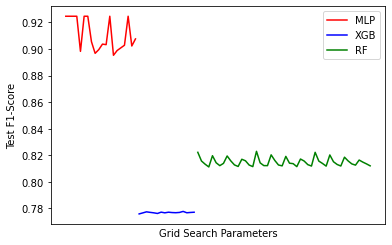

In [22]:
fig,ax = plt.subplots(1,1)
ax.plot(final[final['Model']=='MLP']['Test'],color='r')
ax.plot(final[final['Model']=='XGB']['Test'],color='b')
ax.plot(final[final['Model']=='RF']['Test'],color='g')
ax.legend(['MLP','XGB','RF'])
ax.set_ylabel('Test F1-Score')
ax.set_xlabel('Grid Search Parameters')
ax.set_xticks([])